# Progetto del corso di Quantum Computing

## Caso base: immagine 4x4px

Iniziamo la trattazione con l'implementazione dell'algoritmo di base, nel caso di un'immagine $2^2 \times 2^2$ pixel.

### Import section

In [1]:
import numpy as np
from math import pi

# Grafici
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

L'immagine è volutamente dotata di repentini cambi verticali di intensità ogni 4 righe.

Height: 16, Width: 16


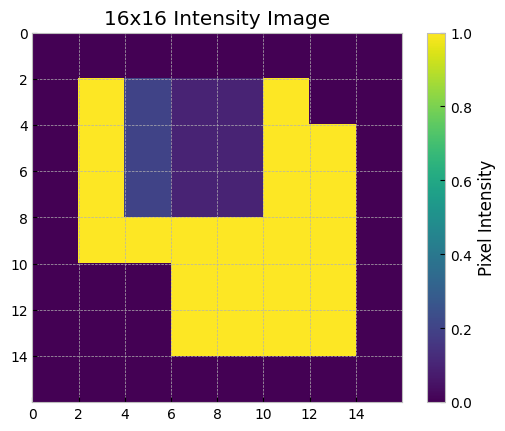

In [18]:
# #A 16x16 image with marked rows
# image = np.array([
#     [(i % 4) * 0.25 for j in range(16)]
#     for i in range(16)
# ])

# A 8x8 binary image
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0.2, 0.1, 0.1, 1, 0, 0],
                  [0, 1, 0.2, 0.1, 0.1, 1, 1, 0],
                  [0, 1, 0.2, 0.1, 0.1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0]])

# Duplicare ogni elemento in un blocco 2x2 per ottenere un'immagine 16x16
image = np.kron(image, np.ones((2, 2)))
height, width = image.shape
print(f"Height: {height}, Width: {width}")


# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(0, img.shape[0], 2))  # Show ticks every 2 pixels for clarity
    plt.yticks(range(0, img.shape[1], 2))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.colorbar(label="Pixel Intensity")
    plt.show()
    
plot_image(image, '16x16 Intensity Image')

Utilizziamo ora la _Quantum Probability Image Encoding_ (QPIE) per codificare le intensità dei pixel:

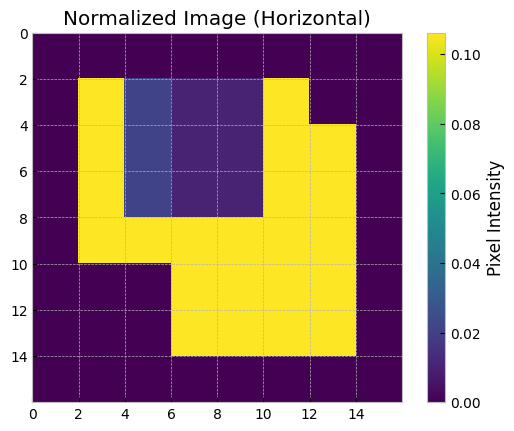

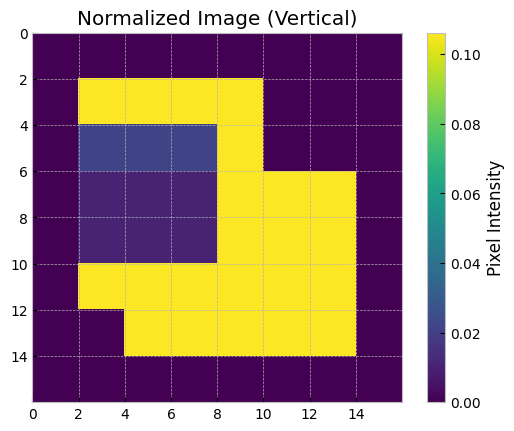

In [3]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

plot_image(image_norm_h.reshape(height, width), 'Normalized Image (Horizontal)')
plot_image(image_norm_v.reshape(height, width), 'Normalized Image (Vertical)')

In [4]:
# Initialize some global variable for number of qubits
data_qb = 8
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


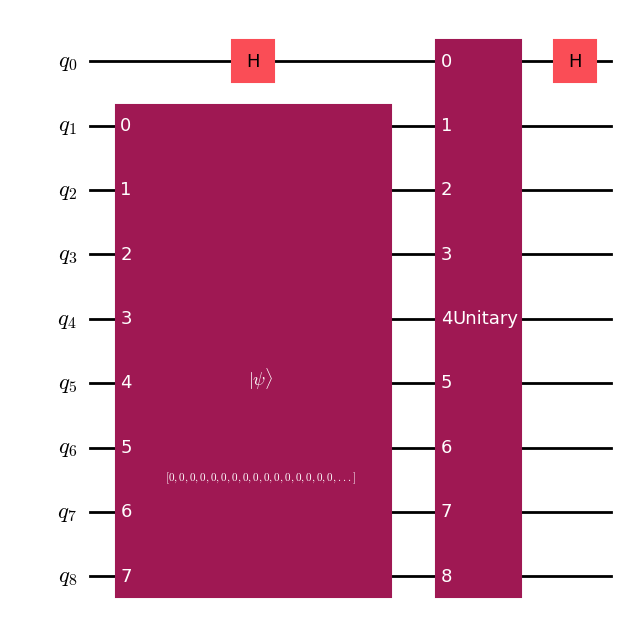

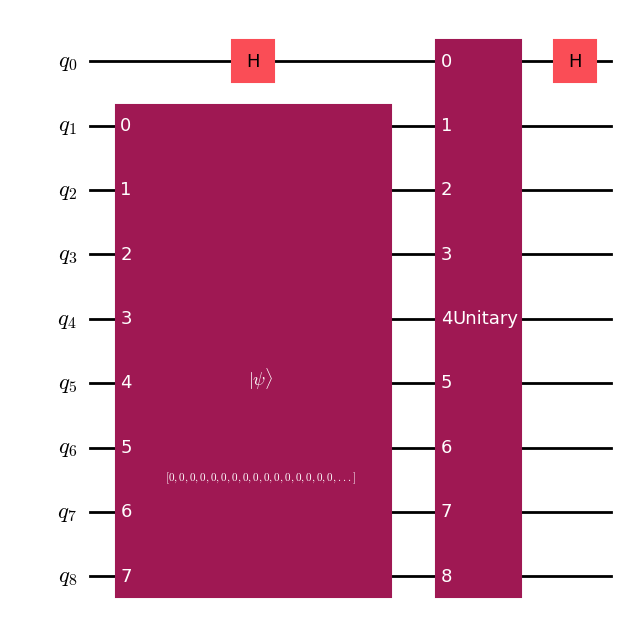

In [5]:
from qiskit import *
from qiskit import transpile
from qiskit_aer import Aer


# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [6]:
# Simulating the circuits
backend = Aer.get_backend('statevector_simulator')
new_circuit = transpile(circ_list, backend)

# Stampa dei circuiti dopo il transpile
# for idx, circuit in enumerate(new_circuit):
#     print(f"Circuito {idx + 1} dopo il transpiling:")
#     print(circuit.draw())

result = backend.run(new_circuit).result()
sv_h = np.array(result.get_statevector(qc_h))
sv_v = np.array(result.get_statevector(qc_v))

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
print(sv_h[:64])
#display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
print(sv_v[:64])
#display(array_to_latex(sv_v[:30], max_size=30))

Horizontal scan statevector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Vertical scan statevector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


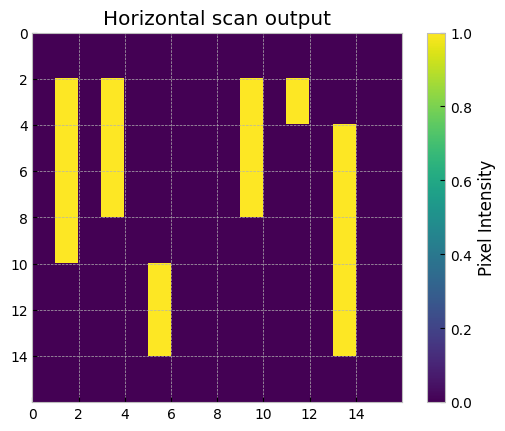

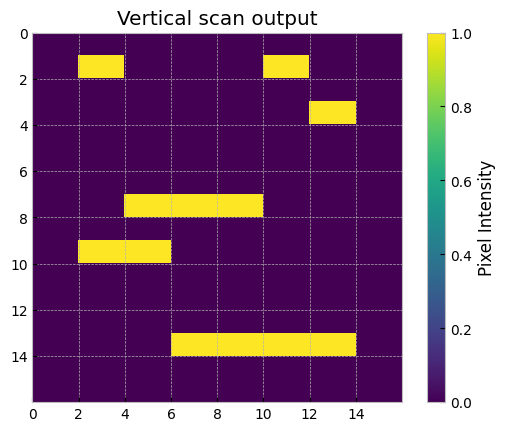

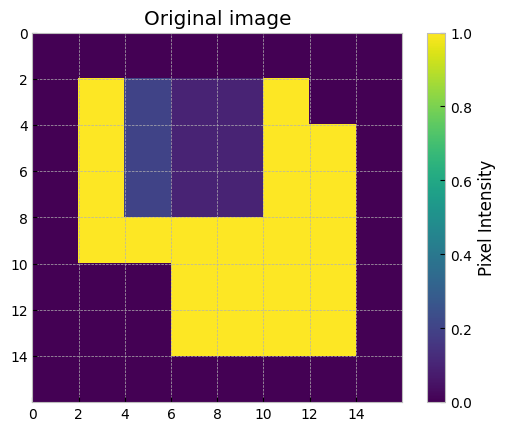

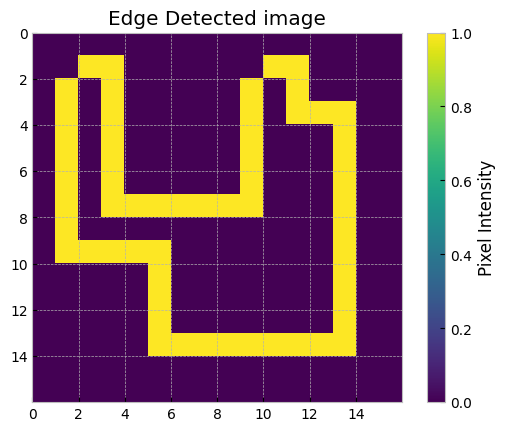

In [7]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
bound=4e-02
threshold = lambda amp: (amp > bound or amp < -bound)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(height, width)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(height, width).T

print(edge_scan_v)

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

## Error handling

Per iniziare, prendiamo un modello di rumore da un chip fisico (`ibm_kyiv`).

In [8]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token="cd9627c6de96e42618ed7038236b7d2bcff428e501b8f6866512731ad43cb60c57f5aff2822718b0e9b71c3d9bc58cda7d21994fe6ec88bbaf5ac128ce2715b3")
print(service.backends())

backend = service.backend("ibm_kyiv")
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


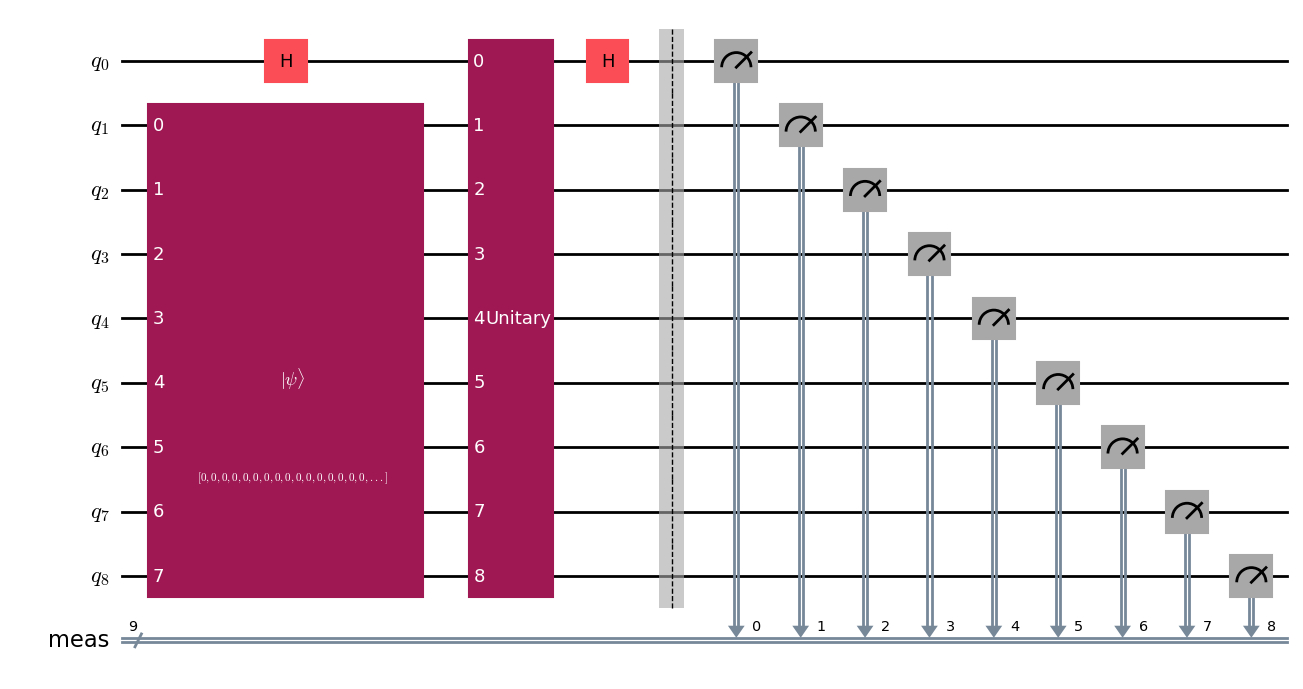

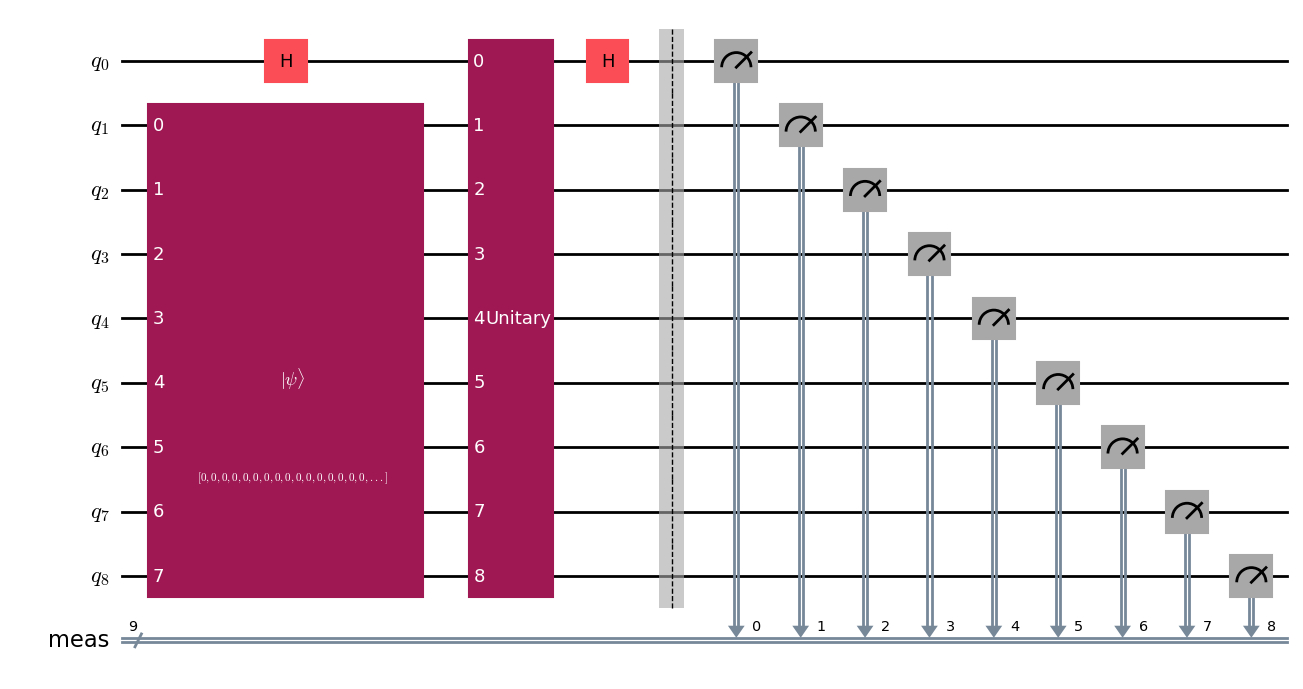

Result(backend_name='aer_simulator', backend_version='0.16.0', qobj_id='', job_id='76ab08a3-6a29-4262-9931-5b15058723c5', success=True, results=[ExperimentResult(shots=65536, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1a1': 1, '0x15': 4, '0x7': 4, '0x69': 2, '0xfd': 3, '0x145': 1, '0x11': 3, '0x1c5': 3, '0x1d': 1, '0x1df': 1, '0x3f': 2, '0x1d5': 6, '0x17f': 3, '0xcd': 3, '0x49': 4, '0x11d': 5, '0xa1': 7, '0x37': 11, '0x25': 4, '0x11f': 7, '0x39': 6, '0x1eb': 15, '0x107': 22, '0xa9': 4, '0x89': 3, '0x17': 8, '0x147': 7, '0x5': 6, '0x16f': 23, '0x35': 5, '0xbd': 1, '0x12d': 28, '0x1': 1, '0x117': 21, '0xb1': 8, '0x1d1': 3, '0x1fe': 16, '0x95': 32, '0x141': 1, '0x18d': 20, '0xa8': 54, '0x31': 3, '0x5d': 1, '0xb': 5, '0x1cd': 7, '0x129': 15, '0x151': 18, '0x9d': 6, '0x55': 27, '0xe1': 4, '0xa0': 25, '0xad': 6, '0x33': 13, '0x1bd': 3, '0x179': 31, '0xbf': 8, '0x1f9': 4, '0x7f': 8, '0xc1': 4, '0x3b': 27, '0xc0': 14, '0x1b': 18, '0x4d': 8, '0x1f5': 9, '0x9f': 4, '0x6b': 

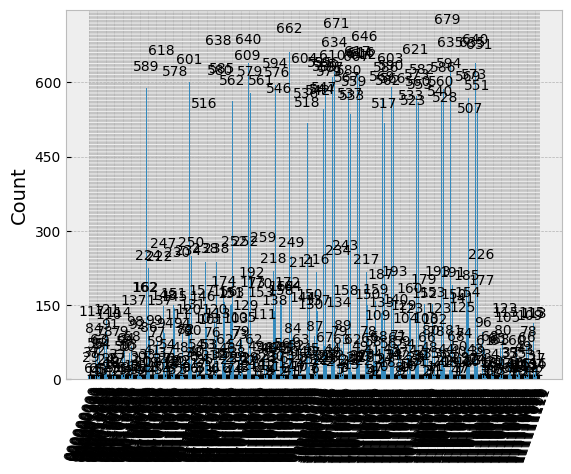



Counts for Vertical scan:


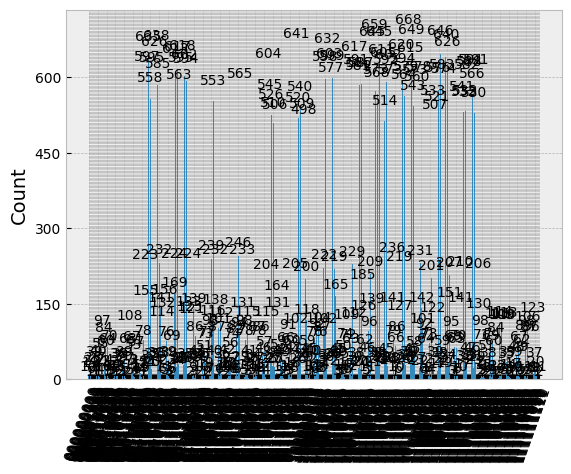

In [34]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
qc_h.measure_all()
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
qc_v.measure_all()
display(qc_v.draw('mpl', fold=-1))

# # Transpile the circuits for optimized execution on the backend
# qc_h_t = transpile(qc_h, backend=backend, optimization_level=3)
# qc_h_v = transpile(qc_v, backend=backend, optimization_level=3)
# print('transpiled!')

# Combine both circuits into a single list
# circ_list = [qc_h_t, qc_h_v]
circ_list = [qc_h, qc_v]

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

from qiskit.visualization import plot_histogram
result = backend.run(circ_list, shots=2**16).result()
print(result)

counts_h = result.get_counts(qc_h)
counts_v = result.get_counts(qc_v)

print('Counts for Horizontal scan:')
display(plot_histogram(counts_h))

print('\n\nCounts for Vertical scan:')
display(plot_histogram(counts_v))

{'000000000': 6,
 '000000001': 1,
 '000000010': 29,
 '000000011': 37,
 '000000100': 117,
 '000000101': 6,
 '000000110': 84,
 '000000111': 4,
 '000001000': 56,
 '000001001': 1,
 '000001010': 42,
 '000001011': 5,
 '000001100': 63,
 '000001101': 5,
 '000001110': 60,
 '000001111': 5,
 '000010000': 54,
 '000010001': 3,
 '000010010': 78,
 '000010011': 24,
 '000010100': 121,
 '000010101': 4,
 '000010110': 110,
 '000010111': 8,
 '000011000': 91,
 '000011010': 26,
 '000011011': 18,
 '000011100': 14,
 '000011101': 1,
 '000011110': 7,
 '000100000': 9,
 '000100001': 2,
 '000100010': 27,
 '000100011': 33,
 '000100100': 114,
 '000100101': 4,
 '000100110': 79,
 '000100111': 8,
 '000101000': 50,
 '000101001': 5,
 '000101010': 58,
 '000101011': 8,
 '000101100': 64,
 '000101101': 4,
 '000101110': 50,
 '000101111': 2,
 '000110000': 53,
 '000110001': 3,
 '000110010': 68,
 '000110011': 13,
 '000110100': 137,
 '000110101': 5,
 '000110110': 98,
 '000110111': 11,
 '000111000': 92,
 '000111001': 6,
 '000111010

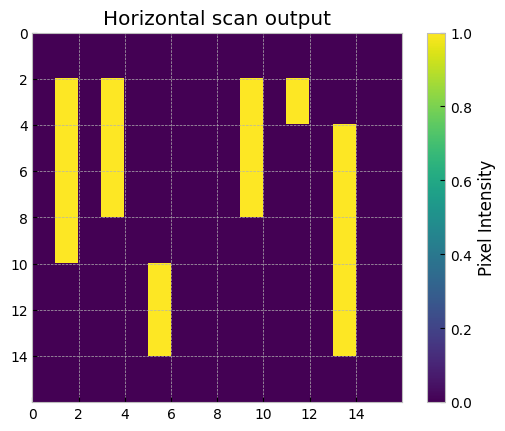

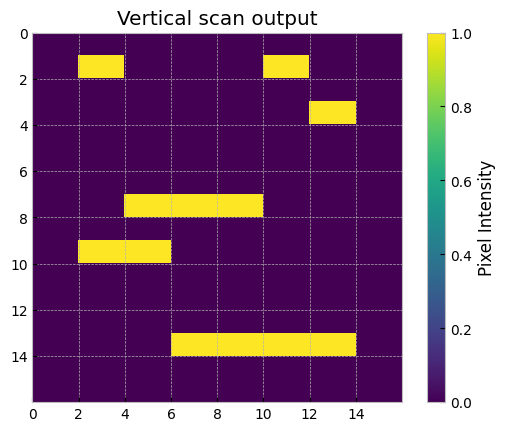

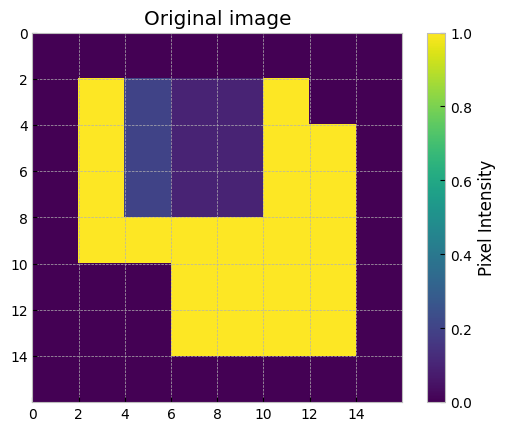

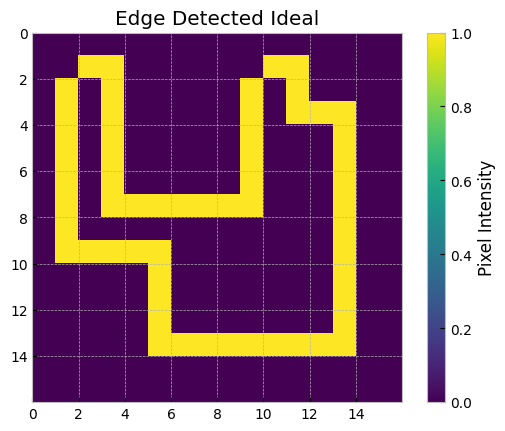

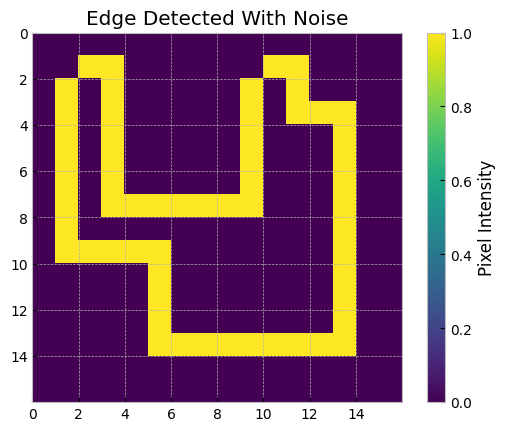

In [39]:
from pprint import pprint

# Extracting counts for odd-numbered states
pprint(counts_h, sort_dicts=True)

# edge_scan_h = np.array([counts_h.get(f'{2*i+1:09b}', 0) for i in range(2**data_qb)]).reshape(height,width)
# edge_scan_v = np.array([counts_v.get(f'{2*i+1:09b}', 0) for i in range(2**data_qb)]).reshape(height,width).T

edge_scan_h = np.array([
    1 if counts_h.get(f'{2*i+1:09b}', 0) > 75 else 0
    for i in range(2**data_qb)
]).reshape(height, width)

edge_scan_v = np.array([
    1 if counts_v.get(f'{2*i+1:09b}', 0) > 75 else 0
    for i in range(2**data_qb)
]).reshape(height, width).T

edge_detected_image = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected Ideal')
plot_image(edge_detected_image, 'Edge Detected With Noise')